In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time
import numpy as np

In [2]:
from ML.svr import svr 
from help_function import cal_mean_squared_error
from help_function import cal_directional_accuracy
from help_function import cal_Tolerance_Based_accuracy

In [3]:
# Load the dataset
train_file_path = "./datasets/Train_Pre_Processed_Dataset.csv"  
train_data = pd.read_csv(train_file_path)

test_file_path = "./datasets/Test_Pre_Processed_Dataset.csv" 
test_data = pd.read_csv(test_file_path)

In [4]:
#Define levels
levels=5

# Parse relevant columns for all bid and ask levels
# bid_columns = [f"bids[{i}].price" for i in range(levels)] + [f"bids[{i}].amount" for i in range(levels)]
# ask_columns = [f"asks[{i}].price" for i in range(levels)] + [f"asks[{i}].amount" for i in range(levels)]
bid_columns = [f"bids[{i}].price" for i in range(levels)]
ask_columns = [f"asks[{i}].price" for i in range(levels)]
feature_columns = bid_columns  + ask_columns

# AdaBoost only predicts a single output

target_columns=['next_1st_mark_price']
eval_columns=target_columns+ ["mark_price",'1st_Price_Movement',"1st_actual_direction"]

# Features and target
X_train = train_data[feature_columns]
y_train = train_data['next_1st_mark_price']
X_test = test_data[feature_columns]
y_test = test_data[eval_columns]

In [5]:
svr_model=svr(X_train,y_train,X_test)

In [6]:
# if not yet trained
# Measure the execution time of the function

# start_time = time.time()
# svr_model.train()
# end_time = time.time()
# training_time = (end_time - start_time)* 1000 
# print(f"Training_time(SVR): {training_time:.2f} milliseconds")

In [7]:
# Predict 
# Measure the execution time of the function
start_time = time.time()
result=svr_model.predict()
end_time = time.time()
execution_time = (end_time - start_time)* 1000 
print(f"Execution_time(SVR): {execution_time:.2f} milliseconds")

Execution_time(SVR): 1287794.70 milliseconds


In [8]:
eval_np_array= np.array(y_test[['next_1st_mark_price',"1st_actual_direction"]])

In [9]:
# Evaluate performance using MSE on evaluation set
mse_svr = cal_mean_squared_error(eval_np_array[:,0], result)
print(f"MSE (SVR): {mse_svr}")

MSE (SVR): [13.71823499]


In [10]:
# Calculate directional accuracy
result_sign = np.sign(result - eval_np_array[:,0])
directional_accuracy_svr=cal_directional_accuracy(eval_np_array[:,1],result_sign)
print(f"Directional Accuracy (SVR): {directional_accuracy_svr}")

Directional Accuracy (SVR): [0.28362269]


In [11]:
# Calculate tolerance-based accuracy
tolerance_accuracy_svr = cal_Tolerance_Based_accuracy(eval_np_array[:,0], result)
print(f"Tolerance-Based Accuracy (SVR): {tolerance_accuracy_svr}")

Tolerance-Based Accuracy (SVR): [0.9030189]


In [12]:
SVR_Predict_data=pd.DataFrame({"predicted_next_1st_mark_price":result
                                            #  "predicted_next_2nd_mark_price":result[:,1],
                                            })

In [13]:
SVR_Performance=pd.DataFrame({"model": "SVR",
                                            "1st_mark_price_mse_AdaBoost": mse_svr[0],
                                             "1st_mark_price_tolerance_accuracy_AdaBoost": tolerance_accuracy_svr[0],
                                             "1st_mark_price_directional_accuracy_AdaBoost": directional_accuracy_svr[0],      
                                            #  "2nd_mark_price_mse_AdaBoost": mse_AdaBoost[1],
                                            #  "2nd_mark_price_tolerance_accuracy_AdaBoost": tolerance_accuracy_AdaBoost[1],
                                            #  "2nd_mark_price_directional_accuracy_AdaBoost": tolerance_accuracy_AdaBoost[1],
                                             "execution_time":execution_time}, index=[0])

In [14]:
Evaluate_result=pd.concat([y_test, SVR_Predict_data], axis=1)

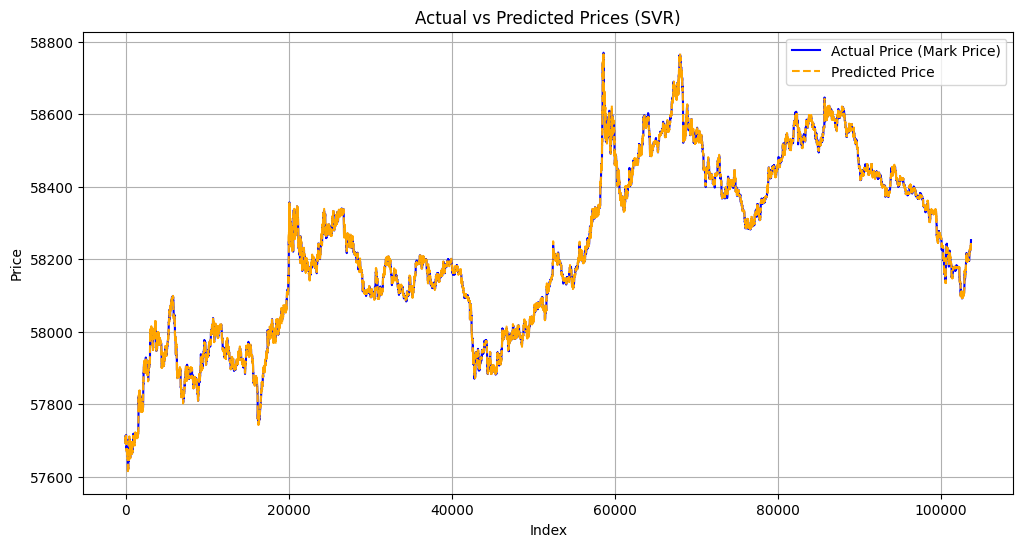

In [15]:
# Visualize the actual vs. predicted price along with signals
plt.figure(figsize=(12, 6))
plt.plot(Evaluate_result["next_1st_mark_price"], label="Actual Price (Mark Price)", color="blue")
plt.plot(Evaluate_result["predicted_next_1st_mark_price"], label="Predicted Price", color="orange", linestyle="--")
plt.title("Actual vs Predicted Prices (SVR)")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()